# 2019-03-07 Allocation of hot dipped galvanised steel production

Changes introduced in commit 045a3a3:

In [1]:
from git import Repo
import pandas as pd
%matplotlib inline

# Load the previous version of the data from the git repository
repo = Repo('../..')
commit = repo.commit('045a3a3')
print(commit.message)

Update allocation of hot dipped galvanised UK production to sectors

The amount of UK-produced steel going to car bodies-in-white manufacturing was
reviewed to be too small. We had already assumed all imported hot-dipped
galvanised steel was going to this sector (15a), but the allocation of UK
production was based on the ISSB tables, which sent only a small amount to
sector 15a. We have revered to Jon Cullen's global estimates of where hot-dipped
galvanised steel is used.



In [2]:
alloc_new = pd.read_csv(commit.tree['allocations/alloc_products_sectors_home.csv'].data_stream)
alloc_old = pd.read_csv(commit.parents[0].tree['allocations/alloc_products_sectors_home.csv'].data_stream)

How has the allocation changed?

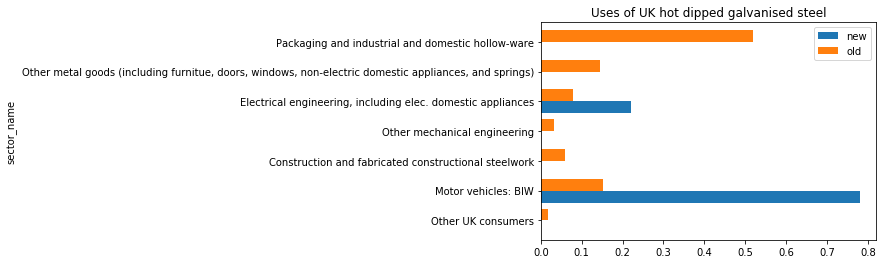

In [3]:
pd.DataFrame({
    label: df.set_index('sector_name')['Hot dipped galvanised'].iloc[::-1].replace({0: None})
    for label, df in dict(new=alloc_new, old=alloc_old).items()
}).dropna(how='all').plot.barh(width=0.8, title='Uses of UK hot dipped galvanised steel');

In [4]:
flows_new = pd.read_csv(commit.tree['data/flows.csv'].data_stream)
flows_old = pd.read_csv(commit.parents[0].tree['data/flows.csv'].data_stream)

What's changed?

In [5]:
differences = pd.merge(flows_old,
                       flows_new, 
                       on=['source', 'target', 'material', 'year'], 
                       indicator=True,
                       how='outer') \
    .query('_merge != "both"')

In one year, we've lost flows to sectors 6, 7, 12, 14 and 20 (because they're now all going to 15a)

In [6]:
differences.query("year == 2016")

,source,target,material,year,value_x,value_y,_merge
11104,uk_production,sector 6,Hot dipped galvanised,2016,246.3,NaN,left_only
11105,sector 6,scrap,scrap Hot dipped galvanised,2016,24.6,NaN,left_only
11106,uk_production,sector 7,Hot dipped galvanised,2016,68.3,NaN,left_only
11107,sector 7,scrap,scrap Hot dipped galvanised,2016,11.6,NaN,left_only
11110,uk_production,sector 12,Hot dipped galvanised,2016,14.7,NaN,left_only
11111,sector 12,scrap,scrap Hot dipped galvanised,2016,2.9,NaN,left_only
11112,uk_production,sector 14,Hot dipped galvanised,2016,28.5,NaN,left_only
11113,sector 14,scrap,scrap Hot dipped galvanised,2016,3.1,NaN,left_only
11117,uk_production,sector 20,Hot dipped galvanised,2016,8.1,NaN,left_only
11118,sector 20,scrap,scrap Hot dipped galvanised,2016,1.4,NaN,left_only


There are also a few changes related to imbalances and whether the output of UK manufacturing goes to exports or UK demand:

In [7]:
differences.query('_merge != "left_only"')

,source,target,material,year,value_x,value_y,_merge
11427,imbalance,products 7,7,1998,NaN,3.9,right_only
11428,imbalance,products 12,12,1999,NaN,19.2,right_only
11429,products 15a,uk_demand,15a,2001,NaN,244.4,right_only
11430,imbalance,products 7,7,2005,NaN,20.9,right_only


## Sankey diagram for 2016

Define the Sankey diagram structure and draw:

In [8]:
sss = pd.read_csv('../../allocations/alloc_products_sectors_home.csv', index_col=0)['sector_name']

In [9]:
from palettable.cartocolors.qualitative import Prism_10, Antique_10
C = Prism_10.hex_colors[1:]

In [10]:
from floweaver import *

# Users of hot dipped galvanized
sectors = ['6', '7', '8', '10', '12', '15a', '14', '20']

sector_names = [
    (sss.loc[s], [s]) for s in sectors
]

manufac_and_products = [
    (sector, ['sector %s' % sector, 'products %s' % sector])
    for sector in sectors
]

relevant_semis = ['Plate', 
                  'Hot dipped galvanised', 
                  'component']

psemi = Partition.Simple('material', relevant_semis)
pprod = Partition.Simple('material', sector_names)

pmat = Partition.Simple('material', [
    ('Flat', ['Hot rolled', 'Plate', 'Cold rolled', 'Hot dipped galvanised',
              'Electro coated', 'Organic coated', 'Tin plate', 'Tubes and pipes']),
    ('Long', ['Railway track material', 'Sheet piling and rolled accessories', 'Heavy sections', 'Light sections',
              'Hot rolled bars in lengths', 'Bright bars', 'Reinforcing bar', 'Rods']),
    ('Metal goods', ['4', '5', '6', '7']),
    ('Elec. eng', ['8']),
    ('Mech. eng', ['9', '10', '11', '12', '13']),
    ('Construction', ['14']),
    ('Transport', ['15a', '15b', '16']),
    ('Energy/water', ['17', '18', '19']),
    ('Other', ['20']),
    'component',
])

nodes = {
    'prod': ProcessGroup(['uk_production'], psemi, title='UK production'),
    'manuf': ProcessGroup([yy for xx in manufac_and_products for yy in xx[1]],
                          Partition.Simple('process', manufac_and_products), title='Manufacturing'),    
    'import': ProcessGroup(['imports', 'component_imports'], psemi, title='Import'),
    'semi_export': ProcessGroup(['exports'], title='Export of steel products'),
}

ordering = [
    [['import'], ['prod'], []],
    [[], ['manuf'], ['semi_export']],
]

bundles = [
    Bundle('prod', 'semi_export'),
    Bundle('prod', 'manuf', waypoints=[]),
    Bundle('import', 'manuf', waypoints=[]),
]

palette = {k: '#999' for k in pmat.labels}
palette['Flat'] = Antique_10.hex_colors[0]
palette['Long'] = Antique_10.hex_colors[2]
palette['Metal goods'] = C[0]
palette['Elec. eng'] = '#499dd9' # C[1]
palette['Mech. eng'] = C[2]
palette['Construction'] = '#8cc425' #C[3]
palette['Transport'] = C[4]
palette['Energy/water'] = '#cc4520' #C[5]
palette['Other'] = '#8f1e76' #C[6]
palette['component'] = Antique_10.hex_colors[1]

sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=pmat)

In [11]:
weave(sdd, flows_old.query('year == "2016"'), palette=palette) \
.to_widget(width=800, height=600, margins=dict(top=50, left=200, right=200), debugging=True, align_link_types=False)

In [12]:
weave(sdd, flows_new.query('year == "2016"'), palette=palette) \
.to_widget(width=800, height=600, margins=dict(top=50, left=200, right=200), debugging=True, align_link_types=False)

## Input of hot dipped galvanised in BIW over time

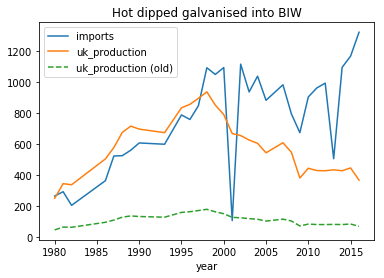

In [13]:
ax = flows_new.query('target == "sector 15a" and material == "Hot dipped galvanised"') \
.pivot(index='year', columns='source', values='value').plot(title='Hot dipped galvanised into BIW')

flows_old.query('target == "sector 15a" and material == "Hot dipped galvanised"') \
.pivot(index='year', columns='source', values='value')['uk_production'].plot(ax=ax, ls='--', label='uk_production (old)');

ax.legend();

In [14]:
flows_new.query('target == "sector 15a" and material == "Hot dipped galvanised"') \
.pivot(index='year', columns='source', values='value')

source,imports,uk_production
year,,
1980,267.6,252.8
1981,295.4,347.4
1982,207.5,340.2
1986,366.5,506.8
1987,525.6,580.2
1988,527.9,678.1
1989,563.2,718.6
1990,610.0,699.3
1993,601.6,676.3
